# Natural Language Processing with Disaster Tweets

Juan Camilo Azuero

## Introduction

This notebook is part of a mini-project of the course Introduction to Deep Learning from the University of Colorado Boulder, and includes a participation in the <a href="https://www.kaggle.com/competitions/nlp-getting-started">Natural Language Processing with Disaster Tweets</a> competition of Kaggle. The purpose of this competition is to develop a model that can predict which tweets are about disasters and which are not, so that disaster relief organizations can monitor the social network and detect emergencies.

## Imports

In [41]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from wordcloud import WordCloud
import itertools
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import datetime
from gensim import downloader
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score
from sklearn.metrics import (
    roc_auc_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

Load data

In [2]:
data_train = pd.read_csv('../Data/train.csv',index_col=0)

In [3]:
data_test = pd.read_csv('../Data/test.csv',index_col=0)

## Exploratory Data Analysis

The Kaggle competition includes a train and test dataset, both of which have columns with the text, location and keyword of the tweet. The train dataset also contains a target binary feature that takes value 1 when the tweet is about a disaster or emergency and 0 otherwise

In [4]:
data_train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data_test.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
print(f'The train dataset has {len(data_train)} tweets, and {data_train["target"].sum()} are about disasters')
print(f'The test dataset contains {len(data_test)} tweets')

The train dataset has 7613 tweets, and 3271 are about disasters
The test dataset contains 3263 tweets


Around 33% of the location column and 0.8% of the keyword column are null values. 

In [7]:
data_train.isna().mean()

keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [8]:
data_train['location'].value_counts().head(30)

USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Mumbai               22
Washington, DC       21
Kenya                20
Worldwide            19
Australia            18
Chicago, IL          18
California           17
Everywhere           15
New York, NY         15
California, USA      15
Florida              14
San Francisco        14
United Kingdom       14
Los Angeles          13
Indonesia            13
Washington, D.C.     13
Toronto              12
NYC                  12
Ireland              12
Seattle              11
Earth                11
Name: location, dtype: int64

As the cell above shows, the location would have to be heavily processed and cleaned for it to be usefull, and is filled with irrelevant values like *earth* or *everywere*. For these reasons this column will be dropped, but in further refinement of the modelling process it should included.

In [9]:
data_train.drop('location',axis=1,inplace=True)
data_test.drop('location',axis=1,inplace=True)

In [10]:
data_train.fillna({'keyword':'None'},inplace=True)
data_test.fillna({'keyword':'None'},inplace=True)

The train dataset is relatively balanced as 43% of the tweets are classified as disaster related, so no resampling will be done.

In [11]:
data_train['target'].value_counts()/len(data_train)

0    0.57034
1    0.42966
Name: target, dtype: float64

The following cells clean the tweets and transform them into a format that a recurrent neural network can handle. This process includes stopword and punctuation removal, and transforming the tweets into lower case.

In [12]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords = ["".join([s for s in w if s not in string.punctuation]) for w in stopwords]

In [13]:
def text_preprocessing(sentence: str):
    sentence = re.sub(r'\n',' ',sentence)
    sentence = ''.join([s.lower() for s in sentence if s not in string.punctuation])
    sentence = [w for w in sentence.split(' ') if w not in stopwords and w != '']
    return [w for w in sentence if w[:4] != 'http']

In [14]:
data_train['text_processed'] = data_train['text'].apply(text_preprocessing)
data_test['text_processed'] = data_test['text'].apply(text_preprocessing)

Let's look at the length distribution of the data

In [15]:
data_train['len'] = data_train['text_processed'].apply(len)

<AxesSubplot:xlabel='len', ylabel='Probability'>

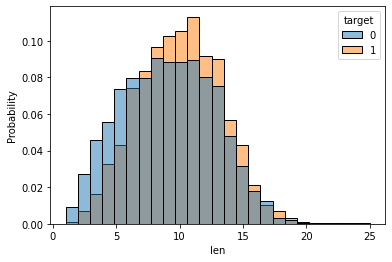

In [16]:
sns.histplot(data=data_train, x='len', bins=25, hue='target', stat='probability',common_norm=False)

The tweets related to emergencies in the train dataset are considerably larger than the other tweets. To finish the data exokiration let's construct a word cloud for both categories.

In [17]:
pos_words = list(itertools.chain(*data_train[data_train['target']==1]['text_processed'].values))
neg_words = list(itertools.chain(*data_train[data_train['target']==0]['text_processed'].values))

In [18]:
word_cloud = WordCloud(
    background_color='White',
    height=500,
    width=800
)

Tweets related to disaster

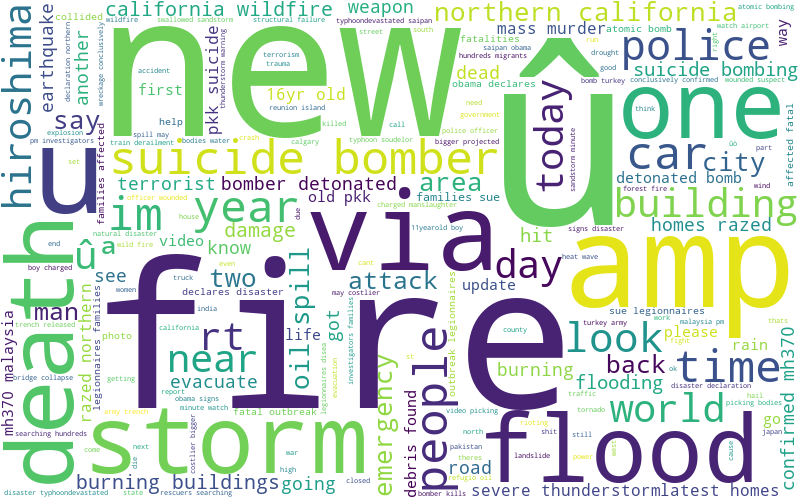

In [19]:
wc = word_cloud.generate_from_text(' '.join(pos_words))
wc.to_image()

Tweets not related to disaster

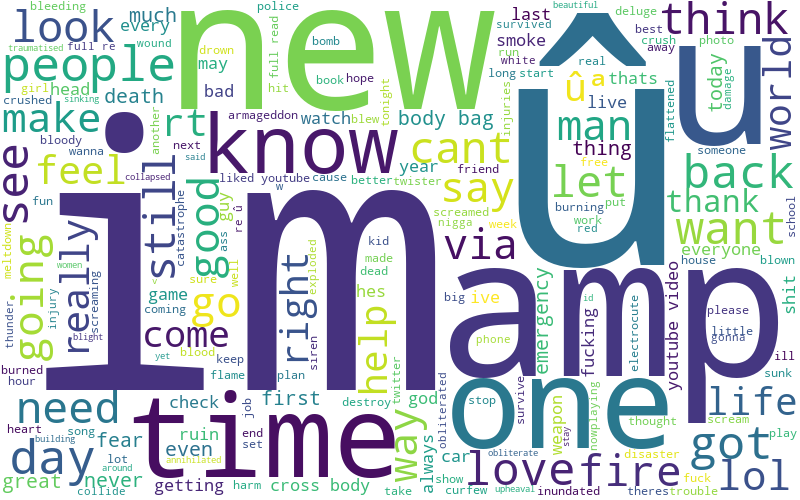

In [20]:
wc = word_cloud.generate_from_text(' '.join(neg_words))
wc.to_image()

Words related to disaster like flood, fire, storm and death are very prominent in the positive word cloud. In the negative labelled tweets these words also appear, but are much smaller, implying that do not appear as often in the text.

## Modelling

For the modelling part of this project the evaluation metric of choice is the F1 score as it is the metric that is being used in the kaggle competition

### Data preparation

Let's split the train data into train and validation sets.

In [21]:
X_train, X_cv, y_train, y_cv = train_test_split(
    data_train[['text_processed']],data_train['target'],
    test_size=0.2,
)

The tweets are now cleaned and transformed into arrays of standarized words, but machine learning models including RNNs require numerical attributes in order to work, so a last transformation of these list of words into numerical arrays is required. 

The first method we are going to use is the Term Frequency - Inverse Document Frequency vectorization technique. This method takes a tweet and produces a vector with the same length of the distinct words of the training data, where each component is proportional to the number of times that term appear in the tweet and is penalized for the amount of tweets containing the word. This technique does not take into account the order of the words and produces a single vector for each tweet, so the result will be used to train a random forest which will serve as a baseline for the neural networks.

In [22]:
vectorizer = TfidfVectorizer()

In [23]:
X_train_tfid = np.array(
    vectorizer.fit_transform(X_train["text_processed"].apply(lambda x: " ".join(x))).todense()
)

In [24]:
X_cv_tfid = np.array(
    vectorizer.transform(X_cv["text_processed"].apply(lambda x: " ".join(x))).todense()
)

A couple of word embedings will also be used to produce sequences of vectors that can be inputed to Recurrent Neural Networks. The methods selected were Word2Vec and Glove. While Word2Vec relies on large neural networks trained on enormous corpuses of text in order to do feature selection, the Glove model is trained using matrix factorization techniques.

In [25]:
word_2_vec = downloader.load('word2vec-google-news-300')
glove = downloader.load('glove-twitter-25')

In [26]:
def vectorize(arr, vectorizer):
    r = None
    for a in arr:
        try:
            if r is None:
                r = np.array([vectorizer[a]])
            else:
                r = np.vstack([r,vectorizer[a]])
        except KeyError:
            pass
    if r is None:
        return np.array([])
    return r

In [27]:
X_train['text_processed_glove'] = X_train['text_processed'].apply(lambda arr: vectorize(arr, glove))
X_train['text_processed_w2v'] = X_train['text_processed'].apply(lambda arr: vectorize(arr, word_2_vec))
X_cv['text_processed_glove'] = X_cv['text_processed'].apply(lambda arr: vectorize(arr, glove))
X_cv['text_processed_w2v'] = X_cv['text_processed'].apply(lambda arr: vectorize(arr, word_2_vec))

In [48]:
data_test['text_processed_glove'] = data_test['text_processed'].apply(lambda arr: vectorize(arr, glove))
data_test['text_processed_w2v'] = data_test['text_processed'].apply(lambda arr: vectorize(arr, word_2_vec))

Keras RNNs require to have as input a matrix of dimensions (NumberOfTweetsInBatch, NumberOfWordsInTweet, WordEmbeddingDimension), but tweets do not have uniform length, so we in the next cells the numerical array representation of tweets will be padded with 0s so that every the shape of the representations of all tweets are the same.

In [28]:
glove_len = len(X_train['text_processed_glove'].iloc[0][0])
w2v_len = len(X_train['text_processed_w2v'].iloc[0][0])

In [29]:
def padArr(arr, arr_size, tot_size):
    if len(arr) == 0:
        return np.zeros((tot_size,arr_size))
    for i in range(len(arr),tot_size):
        arr = np.vstack([arr,np.zeros(arr_size)])
    return arr
def padSer(ser, arr_size):
    tot_size = ser.apply(len).max()
    return ser.apply(lambda arr: padArr(arr, arr_size, tot_size))

In [30]:
X_train['text_processed_glove'] = padSer(X_train['text_processed_glove'],glove_len)
X_cv['text_processed_glove'] = padSer(X_cv['text_processed_glove'],glove_len)
X_train['text_processed_w2v'] = padSer(X_train['text_processed_w2v'],w2v_len)
X_cv['text_processed_w2v'] = padSer(X_cv['text_processed_w2v'],w2v_len)

In [49]:
data_test['text_processed_glove'] = padSer(data_test['text_processed_glove'],glove_len)
data_test['text_processed_w2v'] = padSer(data_test['text_processed_w2v'],w2v_len)

### Random forest baseline

In [33]:
def gen_rf_hyperparameters():
    n_estimators = max(int(10 ** (np.random.random() * 1.5 + 1)), 1)
    max_depth = np.random.choice([1, 2, 5, 10, 20])
    min_samples_leaf = np.random.randint(1, 100)
    max_features = np.random.random()
    return {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_leaf": min_samples_leaf,
        "max_features": max_features,
    }

In [ ]:
f1_score()

In [36]:
n_cv = 10
score = 0
final_params = None
for i in range(n_cv):
    if i % 2 == 0:
        print(
            f"Iteration {i+1} - {n_cv}: CV - {datetime.datetime.today().strftime('%H:%M:%S')}"
        )
    params = gen_rf_hyperparameters()
    model = RandomForestClassifier(**params)
    model.fit(X_train_tfid,y_train)
    pred = model.predict(X_cv_tfid)
    cv_score = f1_score(y_cv,pred)
    if cv_score > score:
        score = cv_score
        final_params = params
        print(f"Iteration {i+1} - F1 score :{score}")

Iteration 1 - 10: CV - 15:02:07
Iteration 0 - F1 score :0.11299435028248588
Iteration 1 - F1 score :0.1825503355704698
Iteration 3 - 10: CV - 15:02:31
Iteration 3 - F1 score :0.4757894736842105
Iteration 5 - 10: CV - 15:04:03
Iteration 7 - 10: CV - 15:05:11
Iteration 9 - 10: CV - 15:05:31


The final F1 score for the random forest after cross validation was about 0.48 which leaves a lot of room for improvement. 

### RNNs

In [50]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

#### Glove SimpleRNN

In [51]:
inputs = keras.layers.Input(shape=(None,glove_len), dtype = tf.float32)
x = keras.layers.Masking(mask_value=0., input_shape=(None, glove_len))(inputs)
x = keras.layers.SimpleRNN(10)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_gs = keras.Model(inputs, outputs)

In [52]:
model_gs.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
)

In [53]:
model_gs.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 25)]        0         
                                                                 
 masking_3 (Masking)         (None, None, 25)          0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 10)                360       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


In [54]:
fit_hist_gs = model_gs.fit(
    x=np.stack(X_train['text_processed_glove']),
    y=y_train,
    validation_data=(np.stack(X_cv['text_processed_glove']), y_cv),
    batch_size=10000,
    epochs = 1000,
    callbacks=[early_stopping],
    verbose=0,
)

2022-07-29 15:35:13.416632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 15:35:14.155097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


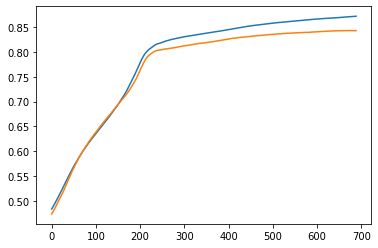

In [59]:
plt.plot(fit_hist_gs.history['auc_3'][1:])
plt.plot(fit_hist_gs.history['val_auc_3'][1:])

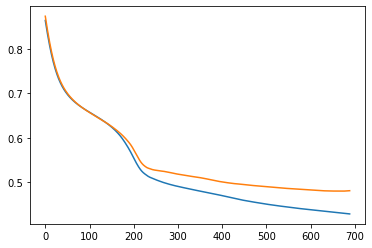

In [60]:
plt.plot(fit_hist_gs.history['loss'][1:])
plt.plot(fit_hist_gs.history['val_loss'][1:])

#### W2V SimpleRNN

In [61]:
inputs = keras.layers.Input(shape=(None,w2v_len), dtype = tf.float32)
x = keras.layers.Masking(mask_value=0., input_shape=(None, w2v_len))(inputs)
x = keras.layers.SimpleRNN(10)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_ws = keras.Model(inputs, outputs)

In [62]:
model_ws.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
)

In [63]:
model_ws.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, 300)]       0         
                                                                 
 masking_4 (Masking)         (None, None, 300)         0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 10)                3110      
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


In [64]:
fit_hist_ws = model_ws.fit(
    x=np.stack(X_train['text_processed_w2v']),
    y=y_train,
    validation_data=(np.stack(X_cv['text_processed_w2v']), y_cv),
    batch_size=10000,
    epochs = 1000,
    callbacks=[early_stopping],
    verbose=0,
)

2022-07-29 15:54:38.742503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 15:54:39.903579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


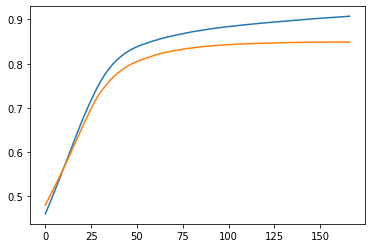

In [65]:
plt.plot(fit_hist_ws.history['auc_4'])
plt.plot(fit_hist_ws.history['val_auc_4'])

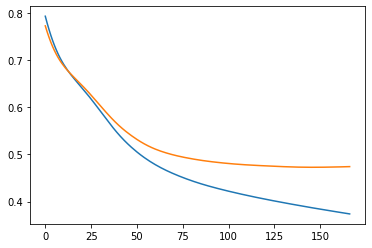

In [66]:
plt.plot(fit_hist_ws.history['loss'])
plt.plot(fit_hist_ws.history['val_loss'])

#### Glove LSTM

In [67]:
inputs = keras.layers.Input(shape=(None,glove_len), dtype = tf.float32)
x = keras.layers.Masking(mask_value=0., input_shape=(None, glove_len))(inputs)
x = keras.layers.LSTM(10)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_gl = keras.Model(inputs, outputs)

In [68]:
model_gl.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
)

In [69]:
model_gl.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, 25)]        0         
                                                                 
 masking_5 (Masking)         (None, None, 25)          0         
                                                                 
 lstm (LSTM)                 (None, 10)                1440      
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,451
Trainable params: 1,451
Non-trainable params: 0
_________________________________________________________________


In [70]:
fit_hist_gl = model_gl.fit(
    x=np.stack(X_train['text_processed_glove']),
    y=y_train,
    validation_data=(np.stack(X_cv['text_processed_glove']), y_cv),
    batch_size=10000,
    epochs = 1000,
    callbacks=[early_stopping],
    verbose=0,
)

2022-07-29 15:57:06.826949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 15:57:07.232243: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2022-07-29 15:57:07.236385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 15:57:07.627964: I tensorflow/co

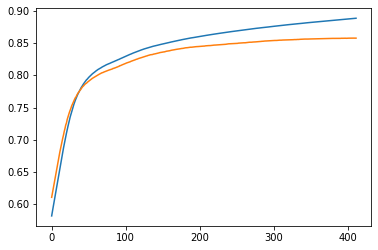

In [71]:
plt.plot(fit_hist_gl.history['auc_5'])
plt.plot(fit_hist_gl.history['val_auc_5'])

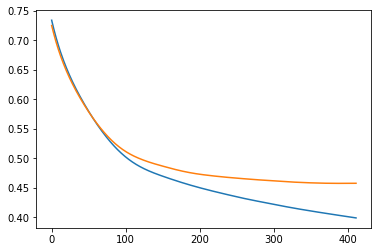

In [72]:
plt.plot(fit_hist_gl.history['loss'])
plt.plot(fit_hist_gl.history['val_loss'])

#### W2V LSTM

In [73]:
inputs = keras.layers.Input(shape=(None,w2v_len), dtype = tf.float32)
x = keras.layers.Masking(mask_value=0., input_shape=(None, w2v_len))(inputs)
x = keras.layers.LSTM(10)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model_wl = keras.Model(inputs, outputs)

In [74]:
model_wl.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
)

In [75]:
model_wl.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, 300)]       0         
                                                                 
 masking_6 (Masking)         (None, None, 300)         0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                12440     
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________


In [76]:
fit_hist_wl = model_wl.fit(
    x=np.stack(X_train['text_processed_w2v']),
    y=y_train,
    validation_data=(np.stack(X_cv['text_processed_w2v']), y_cv),
    batch_size=10000,
    epochs = 1000,
    callbacks=[early_stopping],
    verbose=0,
)

2022-07-29 16:02:48.981385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:02:49.437144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:02:50.006096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:02:51.356340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-29 16:02:51.592081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


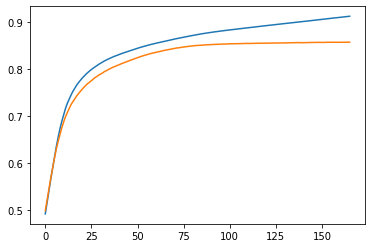

In [77]:
plt.plot(fit_hist_wl.history['auc_6'])
plt.plot(fit_hist_wl.history['val_auc_6'])

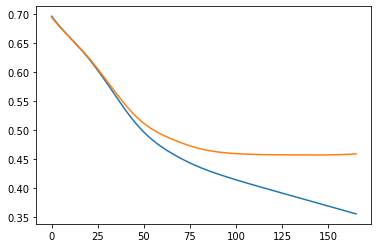

In [78]:
plt.plot(fit_hist_wl.history['loss'])
plt.plot(fit_hist_wl.history['val_loss'])

### Model comparison

Text(0.5, 1.0, 'Binary entropy loss')

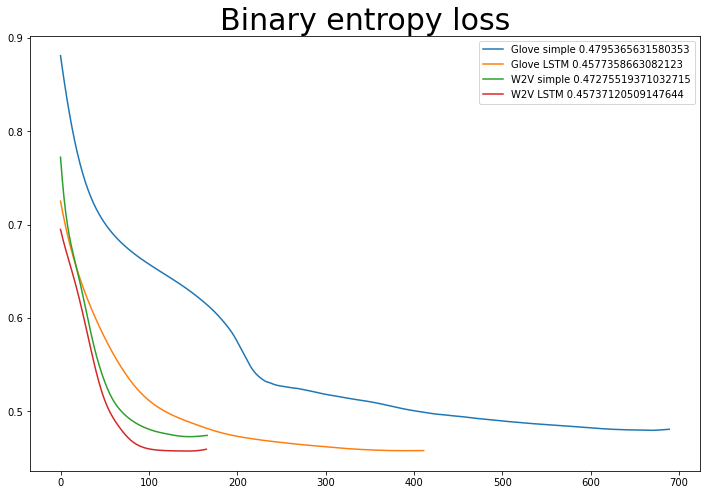

In [87]:
plt.plot(fit_hist_gs.history['val_loss'])
plt.plot(fit_hist_gl.history['val_loss'])
plt.plot(fit_hist_ws.history['val_loss'])
plt.plot(fit_hist_wl.history['val_loss'])
plt.legend([
    f'Glove simple {min(fit_hist_gs.history["val_loss"])}',
    f'Glove LSTM {min(fit_hist_gl.history["val_loss"])}',
    f'W2V simple {min(fit_hist_ws.history["val_loss"])}',
    f'W2V LSTM {min(fit_hist_wl.history["val_loss"])}',
])
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(12,8)
ax.set_title('Binary entropy loss',size=30)

Text(0.5, 1.0, 'AUC')

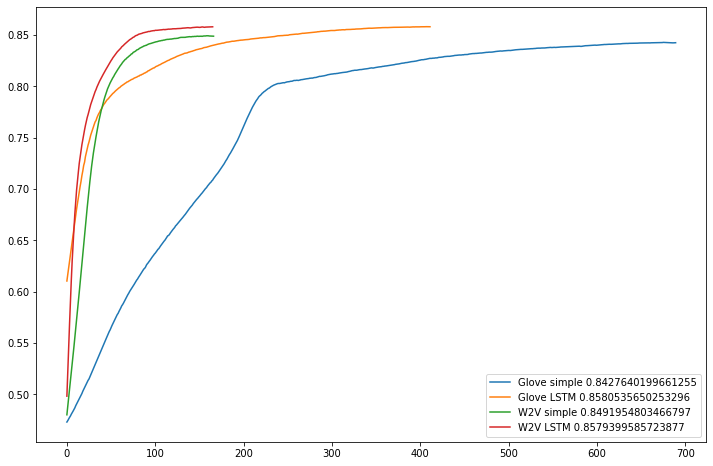

In [92]:
plt.plot(fit_hist_gs.history['val_auc_3'])
plt.plot(fit_hist_gl.history['val_auc_5'])
plt.plot(fit_hist_ws.history['val_auc_4'])
plt.plot(fit_hist_wl.history['val_auc_6'])
plt.legend([
    f'Glove simple {max(fit_hist_gs.history["val_auc_3"])}',
    f'Glove LSTM {max(fit_hist_gl.history["val_auc_5"])}',
    f'W2V simple {max(fit_hist_ws.history["val_auc_4"])}',
    f'W2V LSTM {max(fit_hist_wl.history["val_auc_6"])}',
])
fig = plt.gcf()
fig.set_size_inches(12,8)
ax.set_title('AUC',size=30)

### Model refinement

callbacks

In [34]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

Cross validation one layer

In [32]:
n_cv = 30
best_f1 = 0
best_model = None
fit_hists = []
for i in range(n_cv):
    print(
        f"Iteration {i+1} - {n_cv}: CV - {datetime.datetime.today().strftime('%H:%M:%S')}"
    )
    n_out = np.random.choice([2,5,10,20,50,100])
    dropout = np.random.random()*0.8
    #Model
    inputs = keras.layers.Input(shape=(None,w2v_len), dtype = tf.float32)
    x = keras.layers.Masking(mask_value=0., input_shape=(None, w2v_len))(inputs)
    x = keras.layers.LSTM(n_out, dropout=dropout)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
    )
    #Fit
    fit_hists += [model.fit(
        x=np.stack(X_train['text_processed_w2v']),
        y=y_train,
        validation_data=(np.stack(X_cv['text_processed_w2v']), y_cv),
        batch_size=10000,
        epochs = 1000,
        callbacks=[early_stopping],
        verbose=0,
    )]
    f1_cv = f1_score(
        y_cv.values,
        (model.predict(np.stack(X_cv['text_processed_w2v'])).reshape(-1)>0.5).astype(int)
    )
    if f1_cv > best_f1:
        print(f"Iteration {i+1}, n_out: {n_out}, dropout: {dropout} - F1 score :{f1_cv}")
        best_f1 = f1_cv
        best_model = keras.models.clone_model(model)
        model.save('../data/model_final_1')

Iteration 1 - 30: CV - 19:46:23
Metal device set to: Apple M1 Max
48/48 [==============================] - 1s 9ms/step
Iteration 1, n_out: 2, dropout: 0.6961583802004631 - F1 score :0.7161345987920621


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


Iteration 2 - 30: CV - 19:58:24
48/48 [==============================] - 1s 9ms/step
Iteration 3 - 30: CV - 20:04:19
48/48 [==============================] - 1s 10ms/step
Iteration 4 - 30: CV - 20:06:57
48/48 [==============================] - 1s 9ms/step
Iteration 5 - 30: CV - 20:18:37
48/48 [==============================] - 1s 10ms/step
Iteration 6 - 30: CV - 20:20:20
48/48 [==============================] - 2s 11ms/step
Iteration 6, n_out: 100, dropout: 0.47652030571981724 - F1 score :0.7176616915422885


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


Iteration 7 - 30: CV - 20:22:12
48/48 [==============================] - 1s 10ms/step
Iteration 7, n_out: 50, dropout: 0.6831850287796712 - F1 score :0.7196495619524407


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


Iteration 8 - 30: CV - 20:23:59
48/48 [==============================] - 1s 11ms/step
Iteration 9 - 30: CV - 20:27:44
48/48 [==============================] - 1s 11ms/step
Iteration 10 - 30: CV - 20:29:16
48/48 [==============================] - 1s 11ms/step
Iteration 11 - 30: CV - 20:34:12
48/48 [==============================] - 1s 11ms/step
Iteration 11, n_out: 2, dropout: 0.10138255709643512 - F1 score :0.7238605898123325


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


Iteration 12 - 30: CV - 20:42:06
48/48 [==============================] - 1s 12ms/step
Iteration 13 - 30: CV - 20:43:42
48/48 [==============================] - 1s 12ms/step
Iteration 14 - 30: CV - 20:45:16
48/48 [==============================] - 1s 12ms/step
Iteration 14, n_out: 50, dropout: 0.7529244997034902 - F1 score :0.7517294388931591


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


Iteration 15 - 30: CV - 20:48:10
48/48 [==============================] - 1s 12ms/step
Iteration 15, n_out: 5, dropout: 0.7327413938920314 - F1 score :0.7532894736842105


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


Iteration 16 - 30: CV - 20:58:43
48/48 [==============================] - 1s 12ms/step
Iteration 17 - 30: CV - 21:07:58
48/48 [==============================] - 1s 12ms/step
Iteration 18 - 30: CV - 21:13:26
48/48 [==============================] - 2s 12ms/step
Iteration 19 - 30: CV - 21:17:39
48/48 [==============================] - 1s 12ms/step
Iteration 19, n_out: 20, dropout: 0.22073679154266257 - F1 score :0.7595118449389806


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


INFO:tensorflow:Assets written to: ../data/model_final_1/assets


Iteration 20 - 30: CV - 21:19:47
48/48 [==============================] - 1s 11ms/step
Iteration 21 - 30: CV - 21:22:32
48/48 [==============================] - 1s 12ms/step
Iteration 22 - 30: CV - 21:24:25
48/48 [==============================] - 1s 12ms/step
Iteration 23 - 30: CV - 21:27:30
48/48 [==============================] - 1s 13ms/step
Iteration 24 - 30: CV - 21:29:23
48/48 [==============================] - 1s 14ms/step
Iteration 25 - 30: CV - 21:34:56
48/48 [==============================] - 1s 14ms/step
Iteration 26 - 30: CV - 21:45:09
48/48 [==============================] - 1s 14ms/step
Iteration 27 - 30: CV - 21:49:19
48/48 [==============================] - 1s 15ms/step
Iteration 28 - 30: CV - 21:58:56
48/48 [==============================] - 1s 14ms/step
Iteration 29 - 30: CV - 22:01:42
48/48 [==============================] - 2s 15ms/step
Iteration 30 - 30: CV - 22:03:18
48/48 [==============================] - 2s 15ms/step


Cross validation including 2 layers

In [35]:
n_cv = 30
best_f1 = 0
best_model = None
fit_hists = []
for i in range(n_cv):
    print(
        f"Iteration {i+1} - {n_cv}: CV - {datetime.datetime.today().strftime('%H:%M:%S')}"
    )
    n_out = np.random.choice([2,5,10,20,50,100])
    dropout = np.random.random()*0.8
    n_out_2 = np.random.choice([2,5,10,20,50,100])
    dropout_2 = np.random.random()*0.8
    #Model
    inputs = keras.layers.Input(shape=(None,w2v_len), dtype = tf.float32)
    x = keras.layers.Masking(mask_value=0., input_shape=(None, w2v_len))(inputs)
    x = keras.layers.LSTM(n_out, dropout=dropout, return_sequences=True)(x)
    x = keras.layers.LSTM(n_out_2, dropout=dropout_2)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
    )
    #Fit
    fit_hists += [model.fit(
        x=np.stack(X_train['text_processed_w2v']),
        y=y_train,
        validation_data=(np.stack(X_cv['text_processed_w2v']), y_cv),
        batch_size=10000,
        epochs = 1000,
        callbacks=[early_stopping],
        verbose=0,
    )]
    f1_cv = f1_score(
        y_cv.values,
        (model.predict(np.stack(X_cv['text_processed_w2v'])).reshape(-1)>0.5).astype(int)
    )
    if f1_cv > best_f1:
        print(f"Iteration {i+1}, n: {n_out}, dout: {dropout}, n_2: {n_out_2}, dout_2: {dropout_2} - F1 score :{f1_cv}")
        best_f1 = f1_cv
        best_model = keras.models.clone_model(model)
        model.save('../data/model_final_2')

Iteration 1 - 30: CV - 12:53:14
48/48 [==============================] - 3s 21ms/step
Iteration 1, n: 100, dout: 0.20275382700135902, n_2: 100, dout_2: 0.5963978117029418 - F1 score :0.7347480106100795


INFO:tensorflow:Assets written to: ../data/model_final_2/assets


INFO:tensorflow:Assets written to: ../data/model_final_2/assets


Iteration 2 - 30: CV - 12:56:40
48/48 [==============================] - 3s 19ms/step
Iteration 2, n: 2, dout: 0.016502276773062177, n_2: 2, dout_2: 0.7431641038563173 - F1 score :0.7530674846625767


INFO:tensorflow:Assets written to: ../data/model_final_2/assets


INFO:tensorflow:Assets written to: ../data/model_final_2/assets


Iteration 3 - 30: CV - 13:11:53
48/48 [==============================] - 3s 18ms/step
Iteration 4 - 30: CV - 13:16:54
48/48 [==============================] - 2s 20ms/step
Iteration 5 - 30: CV - 13:32:28
48/48 [==============================] - 2s 20ms/step
Iteration 6 - 30: CV - 13:37:23
48/48 [==============================] - 2s 20ms/step
Iteration 7 - 30: CV - 13:46:09
48/48 [==============================] - 2s 20ms/step
Iteration 7, n: 20, dout: 0.5252583844276464, n_2: 5, dout_2: 0.40937725937057573 - F1 score :0.75592960979342


INFO:tensorflow:Assets written to: ../data/model_final_2/assets


INFO:tensorflow:Assets written to: ../data/model_final_2/assets


Iteration 8 - 30: CV - 13:55:15
48/48 [==============================] - 3s 21ms/step
Iteration 9 - 30: CV - 14:10:29
48/48 [==============================] - 2s 22ms/step
Iteration 10 - 30: CV - 14:22:19
48/48 [==============================] - 3s 22ms/step
Iteration 10, n: 10, dout: 0.06017049657220408, n_2: 100, dout_2: 0.05865403474155837 - F1 score :0.7585206671501088


INFO:tensorflow:Assets written to: ../data/model_final_2/assets


INFO:tensorflow:Assets written to: ../data/model_final_2/assets


Iteration 11 - 30: CV - 14:26:47
48/48 [==============================] - 2s 21ms/step
Iteration 12 - 30: CV - 14:39:27
48/48 [==============================] - 3s 23ms/step
Iteration 12, n: 20, dout: 0.5968809531793224, n_2: 100, dout_2: 0.15737364430924697 - F1 score :0.7619749447310243


INFO:tensorflow:Assets written to: ../data/model_final_2/assets


INFO:tensorflow:Assets written to: ../data/model_final_2/assets


Iteration 13 - 30: CV - 14:46:19
48/48 [==============================] - 3s 21ms/step
Iteration 14 - 30: CV - 15:05:06
48/48 [==============================] - 3s 27ms/step
Iteration 15 - 30: CV - 15:09:57
48/48 [==============================] - 4s 25ms/step
Iteration 15, n: 5, dout: 0.08542173447338319, n_2: 2, dout_2: 0.4326245849039829 - F1 score :0.7651006711409396


INFO:tensorflow:Assets written to: ../data/model_final_2/assets


INFO:tensorflow:Assets written to: ../data/model_final_2/assets


Iteration 16 - 30: CV - 15:21:19
48/48 [==============================] - 3s 25ms/step
Iteration 17 - 30: CV - 15:27:49
48/48 [==============================] - 3s 26ms/step
Iteration 18 - 30: CV - 15:31:19
48/48 [==============================] - 3s 27ms/step
Iteration 19 - 30: CV - 15:35:38
48/48 [==============================] - 3s 27ms/step
Iteration 20 - 30: CV - 15:38:58
48/48 [==============================] - 3s 27ms/step
Iteration 21 - 30: CV - 15:43:58
48/48 [==============================] - 3s 28ms/step
Iteration 22 - 30: CV - 15:52:22
48/48 [==============================] - 3s 28ms/step
Iteration 23 - 30: CV - 16:00:31
48/48 [==============================] - 3s 28ms/step
Iteration 24 - 30: CV - 16:07:40
48/48 [==============================] - 3s 28ms/step
Iteration 25 - 30: CV - 16:19:27
48/48 [==============================] - 3s 28ms/step
Iteration 26 - 30: CV - 16:29:17
48/48 [==============================] - 3s 28ms/step
Iteration 27 - 30: CV - 16:33:12
48/48 [===

INFO:tensorflow:Assets written to: ../data/model_final_2/assets


INFO:tensorflow:Assets written to: ../data/model_final_2/assets


Iteration 28 - 30: CV - 16:49:15
48/48 [==============================] - 3s 27ms/step
Iteration 29 - 30: CV - 16:57:35
48/48 [==============================] - 3s 33ms/step
Iteration 30 - 30: CV - 17:03:07
48/48 [==============================] - 3s 31ms/step


The best model has 2 LSTM layers and achieve a F1_score of 0.77

### Best model

In [38]:
best_pred = model.predict(np.stack(X_cv['text_processed_w2v'])).reshape(-1)

48/48 [==============================] - 1s 17ms/step


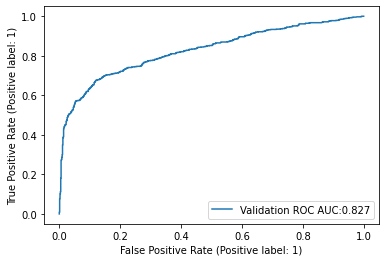

In [42]:
RocCurveDisplay.from_predictions(
    y_cv.values,
    best_pred,
    label=f"Validation ROC AUC:{round(roc_auc_score(y_cv.values, best_pred),3)}",
)

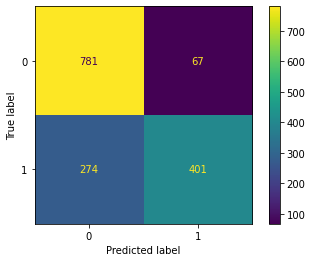

In [45]:
ConfusionMatrixDisplay.from_predictions(
    y_cv.values,
    (best_pred>0.5).astype(int)
)

The confusion matrix and roc curve displayed are evidence of the predictive power of the model, and show that when a tweet is classified to have high probability of being about a disaster it almos certainly is. On the other hand, the model is not thorough enough to identify all tweets that are related to disasters.  

In [63]:
best_pred_train = model.predict(np.stack(X_train['text_processed_w2v'])).reshape(-1)

191/191 [==============================] - 6s 24ms/step


In [67]:
f1_scores = []
best = 0
best_i = -1
for i in range(100):
    f1_scores += [f1_score(y_train, (best_pred_train>(i+1)/100).astype(int))]
    if f1_scores[-1] > best:
        best_i = i
        best = f1_scores[-1]

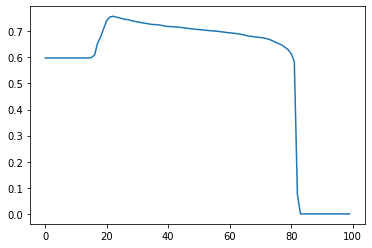

In [70]:
plt.plot(f1_scores)

### Keras submission

In [71]:
test_predictions = model.predict(np.stack(data_test['text_processed_w2v'])).reshape(-1)

102/102 [==============================] - 2s 13ms/step


In [101]:
test_results = pd.DataFrame(index=data_test.index,columns=['target'],data=test_predictions)

In [102]:
test_results_save = test_results.copy()

In [107]:
th = (best_i+1)/100

In [105]:
test_results_save['target'] = test_results_save['target'].apply(lambda x: int(x>th))

In [106]:
test_results_save.to_csv('../Data/kaggle_submission.csv')

## Conclusion

Using Keras a NLP model that can infer if a tweet is about a disaster or not was constructed. In the modelling process various word embeddings, model architechtures and hyperparameters were tested in order to find the model that gave the best reults. The resulting model has two LSTM layers followed by a dense layer used for prediction and achieved a f1 score of around 0.77. Some options for improving the results include refining the feature extraction process by trying other models like attention NNs and searching over more RNN architechtures.